<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20241126%5D%20Hybrid%20combination%20of%20LR-Bi-LSTM%20for%209%20class%20classifications%20on%20NF-ToN-IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid LR-Bi-LSTM for 10 class classifications based on UNSW-NB15 dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [2]:
# Load dataset
dataset = pd.read_csv("Dataset_NF-ToN-IoT.csv")

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values
#X = dataset.drop(['Class'], axis=1)
#y = dataset['Class']

In [3]:
dataset

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Class
0,63318,443,6,91.00,181,165,2,1,24,327,0,Benign,0
1,57442,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
2,57452,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
3,138,138,17,10.16,472,0,2,0,0,0,0,Benign,0
4,51989,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,443,54560,6,91.00,52,52,1,1,17,15,0,Benign,0
1048571,443,54594,6,91.00,52,52,1,1,17,11,0,Benign,0
1048572,443,54582,6,91.00,52,52,1,1,17,11,0,Benign,0
1048573,443,54592,6,91.00,52,52,1,1,17,11,0,Benign,0


### **Data Preprocessing**

In [4]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [5]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [164866  17243 149605  10732 454755 135353    142  15966  99913]


In [6]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the data
#smote = SMOTE(random_state=42)
#X_balanced, y_balanced = smote.fit_resample(X, y)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))
#print("Balanced Class Distribution:", np.bincount(y_balanced))

Balanced Class Distribution: [454755 454755 454755 454755 454755 454755 454755 454755 454755]


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **Hybrid combination of LR-Bi-LSTM for 10 class classifications on UNSW-NB15**

LR model Standalone

In [ ]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=800, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred))

Hybrid model with using features results from LR model as Bi-LSTM input

In [10]:
from keras.utils import to_categorical

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Extract probabilities from LR model
train_lr_features = lr_model.predict_proba(X_train)  # Features for Bi-LSTM from training data
test_lr_features = lr_model.predict_proba(X_test)    # Features for Bi-LSTM from test data

# Reshape LR features for Bi-LSTM input
train_lr_features = np.expand_dims(train_lr_features, axis=1)
test_lr_features = np.expand_dims(test_lr_features, axis=1)

# Convert labels to one-hot encoding for Bi-LSTM
y_train = to_categorical(y_train, num_classes=9)
y_test = to_categorical(y_test, num_classes=9)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [11]:
## Build the Bi-LSTM model

#bilstm_model = Sequential()
#bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, train_lr_features.shape[2])))
#bilstm_model.add(Dropout(0.5))
#bilstm_model.add(Bidirectional(LSTM(32)))
#bilstm_model.add(Dropout(0.5))
#bilstm_model.add(Dense(10, activation='softmax'))  # 10 classes

#bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.regularizers import l2

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))))
bilstm_model.add(Dropout(0.2))
#bilstm_model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))))
#bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(9, activation='softmax', kernel_regularizer=l2(0.0001)))

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Bi-LSTM model
history = bilstm_model.fit(train_lr_features, y_train, validation_split=0.2, epochs=20, batch_size=64, verbose=1)

# Evaluate the hybrid model on the test set
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
print("\nHybrid Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, test_predictions_labels))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 361s 8ms/step - accuracy: 0.9981 - loss: 0.0638 - val_accuracy: 0.9999 - val_loss: 0.0141
Epoch 2/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 379s 8ms/step - accuracy: 0.9999 - loss: 0.0145 - val_accuracy: 0.9999 - val_loss: 0.0140
Epoch 3/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 346s 8ms/step - accuracy: 0.9999 - loss: 0.0143 - val_accuracy: 0.9999 - val_loss: 0.0142
Epoch 4/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 374s 8ms/step - accuracy: 0.9999 - loss: 0.0144 - val_accuracy: 0.9998 - val_loss: 0.0142
Epoch 5/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 387s 8ms/step - accuracy: 0.9999 - loss: 0.0144 - val_accuracy: 0.9999 - val_loss: 0.0141
Epoch 6/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 383s 8ms/step - accuracy: 0.9999 - loss: 0.0143 - val_accuracy: 0.9999 - val_loss: 0.0148
Epoch 7/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 399s 9ms/step - accuracy: 0.9999 - loss: 0.0143 - val_accuracy: 0.9999 - val_loss: 0.0141
Epoch 8/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 380s 9ms/step - ac

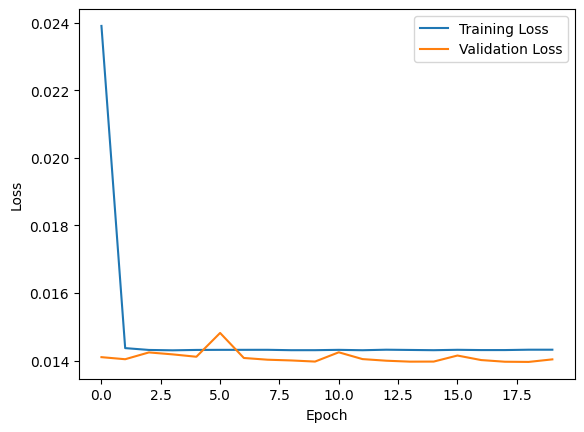

In [12]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')

print("\nHybrid Model Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1)


Hybrid Model Accuracy: 0.9998924940047083

Precision: 0.9998925166019903

Recall: 0.9998924940047083

F1-Score: 0.999892494869149


In [14]:
# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90951
           1       1.00      1.00      1.00     90951
           2       1.00      1.00      1.00     90951
           3       1.00      1.00      1.00     90951
           4       1.00      1.00      1.00     90951
           5       1.00      1.00      1.00     90951
           6       1.00      1.00      1.00     90951
           7       1.00      1.00      1.00     90951
           8       1.00      1.00      1.00     90951

    accuracy                           1.00    818559
   macro avg       1.00      1.00      1.00    818559
weighted avg       1.00      1.00      1.00    818559



In [15]:
# Detection Rate (Recall for each class)
detection_rate = recall_score(true_labels, test_predictions_labels, average=None)
for i in range(len(detection_rate)):
    print(f"Detection Rate for Class {i}: {detection_rate[i]:.10f}")

Detection Rate for Class 0: 1.0000000000
Detection Rate for Class 1: 1.0000000000
Detection Rate for Class 2: 0.9999340304
Detection Rate for Class 3: 0.9996151774
Detection Rate for Class 4: 0.9998350760
Detection Rate for Class 5: 0.9998900507
Detection Rate for Class 6: 1.0000000000
Detection Rate for Class 7: 0.9997581115
Detection Rate for Class 8: 1.0000000000


**With FGSM adversarial training**

In [ ]:
import tensorflow as tf
from keras.regularizers import l2

#Build the Bi-LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=(1, train_lr_features.shape[2])))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
#bilstm_model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))))
#bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.001)))

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# FGSM: Function to generate adversarial examples
def generate_adversarial_examples(model, data, labels, epsilon=0.1):
    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(data_tensor)
        predictions = model(data_tensor)
        loss = tf.keras.losses.categorical_crossentropy(labels_tensor, predictions)

    gradients = tape.gradient(loss, data_tensor)
    perturbations = epsilon * tf.sign(gradients)
    adversarial_data = data_tensor + perturbations

    return adversarial_data.numpy()

# Generate adversarial examples for training
adversarial_train_features = generate_adversarial_examples(bilstm_model, train_lr_features, y_train)

# Combine original and adversarial examples
combined_train_features = np.concatenate((train_lr_features, adversarial_train_features), axis=0)
combined_train_labels = np.concatenate((y_train, y_train), axis=0)

# Train the Bi-LSTM model
history = bilstm_model.fit(
    combined_train_features, combined_train_labels,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Metrics and results
accuracy = accuracy_score(true_labels, test_predictions_labels)
print("\nHybrid Model Accuracy with FGSM:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, test_predictions_labels))

Epoch 1/15
18600/18600 [==============================] - 91s 5ms/step - loss: 0.1807 - accuracy: 0.9988 - val_loss: 0.1139 - val_accuracy: 0.9998
Epoch 2/15
18600/18600 [==============================] - 80s 4ms/step - loss: 0.1241 - accuracy: 0.9999 - val_loss: 0.1114 - val_accuracy: 0.9998
Epoch 3/15
18600/18600 [==============================] - 83s 4ms/step - loss: 0.1225 - accuracy: 0.9999 - val_loss: 0.1112 - val_accuracy: 0.9998
Epoch 4/15
18600/18600 [==============================] - 84s 5ms/step - loss: 0.1224 - accuracy: 0.9999 - val_loss: 0.1108 - val_accuracy: 0.9998
Epoch 5/15
18600/18600 [==============================] - 84s 5ms/step - loss: 0.1223 - accuracy: 0.9999 - val_loss: 0.1109 - val_accuracy: 0.9998
Epoch 6/15
18600/18600 [==============================] - 80s 4ms/step - loss: 0.1223 - accuracy: 0.9999 - val_loss: 0.1111 - val_accuracy: 0.9998
Epoch 7/15
18600/18600 [==============================] - 80s 4ms/step - loss: 0.1223 - accuracy: 0.9999 - val_loss: 0

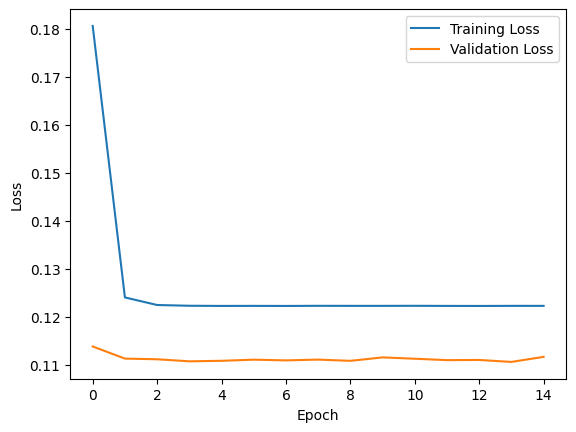

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')

print("\nHybrid Model Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1)


Hybrid Model Accuracy: 0.9997741935483871

Precision: 0.9997744617690524

Recall: 0.9997741935483871

F1-Score: 0.9997741699732392


In [ ]:
# Detection Rate (Recall for each class)
detection_rate = recall_score(true_labels, test_predictions_labels, average=None)
for i in range(len(detection_rate)):
    print(f"Detection Rate for Class {i}: {detection_rate[i]:.10f}")

Detection Rate for Class 0: 1.0000000000
Detection Rate for Class 1: 1.0000000000
Detection Rate for Class 2: 1.0000000000
Detection Rate for Class 3: 1.0000000000
Detection Rate for Class 4: 1.0000000000
Detection Rate for Class 5: 0.9999462366
Detection Rate for Class 6: 0.9979569892
Detection Rate for Class 7: 0.9998387097
Detection Rate for Class 8: 1.0000000000
Detection Rate for Class 9: 1.0000000000
